
<h1>Задание 1</h1>

У вас есть небольшой искусственный датасет: https://www.kaggle.com/datasets/iamsouravbanerjee/customer-shopping-trends-dataset/data   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from collections import Counter
from scipy.stats import ttest_ind
from scipy.stats import pearsonr


#Задание 1.1

На основании этих данных необходимо составить максимальное(но не менее пяти) количество гипотез о корреляциях между отдельными столбцами и проверить их.

При этом при составлении гипотез можно рассматривать не полный df, а именно выборки (например: "женщины старше 40 лет покупают в основном осенью")

In [2]:
data = pd.read_csv("shopping_trends_updated.csv")
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [3]:
df.head(10)

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually
5,6,46,Male,Sneakers,Footwear,20,Wyoming,M,White,Summer,2.9,Yes,Standard,Yes,Yes,14,Venmo,Weekly
6,7,63,Male,Shirt,Clothing,85,Montana,M,Gray,Fall,3.2,Yes,Free Shipping,Yes,Yes,49,Cash,Quarterly
7,8,27,Male,Shorts,Clothing,34,Louisiana,L,Charcoal,Winter,3.2,Yes,Free Shipping,Yes,Yes,19,Credit Card,Weekly
8,9,26,Male,Coat,Outerwear,97,West Virginia,L,Silver,Summer,2.6,Yes,Express,Yes,Yes,8,Venmo,Annually
9,10,57,Male,Handbag,Accessories,31,Missouri,M,Pink,Spring,4.8,Yes,2-Day Shipping,Yes,Yes,4,Cash,Quarterly


In [4]:
df.describe().applymap(lambda x:f'{x:.2f}')[['Age','Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']]

<ipython-input-4-9deda90d9bec>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.describe().applymap(lambda x:f'{x:.2f}')[['Age','Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']]


,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.00,3900.00,3900.00,3900.00
mean,44.07,59.76,3.75,25.35
std,15.21,23.69,0.72,14.45
min,18.00,20.00,2.50,1.00
25%,31.00,39.00,3.10,13.00
50%,44.00,60.00,3.70,25.00
75%,57.00,81.00,4.40,38.00
max,70.00,100.00,5.00,50.00


In [5]:
df.describe(include='object')[['Gender','Item Purchased', 'Category', 'Location',
                               'Size', 'Color', 'Season', 'Subscription Status',
                               'Shipping Type', 'Discount Applied', 'Promo Code Used',
                               'Payment Method', 'Frequency of Purchases']]


,Gender,Item Purchased,Category,Location,Size,Color,Season,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Payment Method,Frequency of Purchases
count,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900
unique,2,25,4,50,4,25,4,2,6,2,2,6,7
top,Male,Blouse,Clothing,Montana,M,Olive,Spring,No,Free Shipping,No,No,PayPal,Every 3 Months
freq,2652,171,1737,96,1755,177,999,2847,675,2223,2223,677,584


Нулевая гипотеза: средняя цена товаров у мужчин и женщин не различаются

Альтернативная гипотеза : средняя цена товаров у мужчин и женщин различаются

Уровень значимости выбираю равным 0.05

In [6]:
male_purchase = df[df['Gender'] == 'Male']['Purchase Amount (USD)']
female_purchase = df[df['Gender'] == 'Female']['Purchase Amount (USD)']

#Проводим t-test
t_stat, p_value = ttest_ind(male_purchase, female_purchase, nan_policy='omit')
print(f"T-statistic: {t_stat}, p-value: {p_value}")

#Интерпретация результата
if p_value > 0.05:
    print(
        "На урвоне значимости 0.05 мы не можем отвергнуть нулевую гипотезу, "
        "мы не можем утверждать, что средняя цена товаров у мужчин и женщин различаются."
    )
else:
    print(
        "Нулевая гипотеза отвергается в пользу альтернативной, "
        "средняя цена товаров у мужчин и женщин различаются на урвоне значимости 0.05"
    )

T-statistic: -0.8769152065030424, p-value: 0.38058673555268097
На урвоне значимости 0.05 мы не можем отвергнуть нулевую гипотезу, мы не можем утверждать, что средняя цена товаров у мужчин и женщин различаются.


Нулевая гипотеза: средний возраст покупателей мужчин и женщин не различаются

Альтернативная гипотеза : средний возраст покупателей мужчин и женщин различаются

Уровень значимости выбираю равным 0.05

In [7]:
male_purchase = df[df['Gender'] == 'Male']['Age']
female_purchase = df[df['Gender'] == 'Female']['Age']

#Проводим t-test
t_stat, p_value = ttest_ind(male_purchase, female_purchase, nan_policy='omit')
print(f"T-statistic: {t_stat}, p-value: {p_value}")

#Интерпретация результата
if p_value > 0.05:
    print(
        "На урвоне значимости 0.05 ы не можем отвергнуть нулевую гипотезу, "
        "мы не можем утверждать, что средний возраст покупателей мужчин и женщин различаются."
    )
else:
    print(
        "Нулевая гипотеза отвергается в пользу альтернативной, "
        "средний средний возраст покупателей мужчин и женщин "
        "различаются на урвоне значимости 0.05"
    )

T-statistic: 0.17252201296583758, p-value: 0.8630361135664557
На урвоне значимости 0.05 ы не можем отвергнуть нулевую гипотезу, мы не можем утверждать, что средний возраст покупателей мужчин и женщин различаются.


Основная гипотеза: мужчины и женщины покупают одежду одинакового размера

Альтернативная: мужчины и женщины покупают одежду разного размера

Уровень значимости: 0,05

In [8]:
df['Size'].unique()

array(['L', 'S', 'M', 'XL'], dtype=object)

In [9]:
size_mapping = {'S': 1, 'M': 2, 'L': 3, 'XL': 4, 'XXL': 5}
df['Size_numeric'] = df['Size'].map(size_mapping)

male_purchase = df[df['Gender'] == 'Male']['Size_numeric']
female_purchase = df[df['Gender'] == 'Female']['Size_numeric']

#Проводим t-test
t_stat, p_value = ttest_ind(male_purchase, female_purchase, nan_policy='omit')
print(f"T-statistic: {t_stat}, p-value: {p_value}")

#Интерпретация результата
if p_value > 0.05:
    print(
        "На урвоне значимости 0.05 мы не можем отвергнуть нулевую гипотезу, "
        "мы не можем утверждать, что женщины и мужчины покупают одежду разного размера."
    )
else:
    print(
        "Нулевая гипотеза отвергается в пользу альтернативной, "
        "женщины и мужчины покупают одежду разного размера "
        "на урвоне значимости 0.05"
    )

T-statistic: -0.7254775283006095, p-value: 0.4682026768649411
На урвоне значимости 0.05 мы не можем отвергнуть нулевую гипотезу, мы не можем утверждать, что женщины и мужчины покупают одежду разного размера.


Нулевая гипотеза: женщины и мужчины одинаково часто покупают товары из категории аксессуары

Альтернативная гипотеза : женщины и мужчины покупают товары из категории аксессуары c разной частотой

Уровень значимости выбираю равным 0.05

In [10]:
accessories_df = df[df['Category'] == 'Accessories']

#Считаем количество покупок аксессуаров для каждого пола
women_accessories = accessories_df[accessories_df['Gender'] == 'Female'].shape[0]
men_accessories = accessories_df[accessories_df['Gender'] == 'Male'].shape[0]

#Считаем общеее количетсво покупок для каждого пола
women_total = df[df['Gender'] == 'Female'].shape[0]
men_total = df[df['Gender'] == 'Male'].shape[0]

print(f"Женщины, купившие аксессуары: {women_accessories}, всего женщин: {women_total}")
print(f"Мужчины, купившие аксессуары: {men_accessories}, всего мужчин: {men_total}")

#Таблица сопряженности
contingency_table = [[women_accessories, women_total - women_accessories],
                     [men_accessories, men_total - men_accessories]]

#Вычисляем хи-квадрат
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2: {chi2}, p-value: {p_value}")

#Интерпретация результата
if p_value > 0.05:
    print(
        "На урвоне значимости 0.05 мы не можем отвергнуть нулевую гипотезу, "
        "мы не можем утверждать, что женщины покупают аксессураы чем мужчины"
    )
else:
    print(
        "Нулевая гипотеза отвергается в пользу альтернативной, "
        "женщины и мужчины покупают аксессуары с разной частотой "
        "на урвоне значимости 0.05"
    )

Женщины, купившие аксессуары: 392, всего женщин: 1248
Мужчины, купившие аксессуары: 848, всего мужчин: 2652
Chi2: 0.1004706716090502, p-value: 0.7512655391929199
На урвоне значимости 0.05 мы не можем отвергнуть нулевую гипотезу, мы не можем утверждать, что женщины покупают аксессураы чем мужчины


Основная гипотеза: связи между возрастом и ценой товара нет

Альтернаятивная гипотеза: связь между возрастом и ценой товара есть

Уровень значимости: 0,05

In [11]:
#Высчитываем корреляцию и p value
correlation, p_value = pearsonr(df['Age'], df['Purchase Amount (USD)'])

print(f'Значение корреляции Пирсона:{correlation}, p value: {p_value}')

#Интерпретация результата
if p_value > 0.05:
    print(
        "На урвоне значимости 0.05 мы не можем отвергнуть нулевую гипотезу, "
        "мы не можем утверждать, связь между ценой товара и возрастом есть"
    )
else:
    print(
        "Нулевая гипотеза отвергается в пользу альтернативной, "
        "связь между возрастом и ценой товара есть "
        "на урвоне значимости 0.05"
    )

Значение корреляции Пирсона:-0.010423647378686536, p value: 0.5151978241224925
На урвоне значимости 0.05 мы не можем отвергнуть нулевую гипотезу, мы не можем утверждать, связь между ценой товара и возрастом есть


Основная гипотеза: возраст покупателя и его оценка товара не связаны

Альтернаятивна гипотеза: возраст покупателя и его оценка товара связаны

Уровень значимости: 0,05

In [12]:
#Высчитываем корреляцию и p value
correlation, p_value = pearsonr(df['Age'], df['Review Rating'])

print(f'Значение корреляции Пирсона:{correlation}, p value: {p_value}')

#Интерпретация результата
if p_value > 0.05:
    print(
        "На урвоне значимости 0.05 мы не можем отвергнуть нулевую гипотезу, "
        "мы не можем утверждать, что возраст покупателя и его оценка товара связаны"
    )
else:
    print(
        "Нулевая гипотеза отвергается в пользу альтернативной, "
        "связь между возрастом и его оценкой товара есть "
        "на урвоне значимости 0.05"
    )

Значение корреляции Пирсона:-0.021949148075933275, p value: 0.17054661545044403
На урвоне значимости 0.05 мы не можем отвергнуть нулевую гипотезу, мы не можем утверждать, что возраст покупателя и его оценка товара связаны


#Задание 1.2

Помимо гипотез:
* найдите самый популярный товар
* постройте распределение покупателей по полу
* определите, какой пол (и отдельно возраст) покупает больше всего, чаще всего, самые дорогие товары
* определите, есть ли зависимость между цветом одежды и сезоном.
* посчитайте наш сезонный mau (уникальных пользователей за сезон) и его динамику.
* найдите самую популярную букву в названии одежды.

##Найдите самый популярный товар

In [13]:

df_value_counts = df['Item Purchased'].value_counts()
max_frequency = max(df_value_counts)
most_popular_values = df_value_counts[df_value_counts == max_frequency]
print(f'Самые популярные товары: {most_popular_values}')


Самые популярные товары: Item Purchased
Blouse     171
Jewelry    171
Pants      171
Name: count, dtype: int64


##Постройте распределение покупателей по полу

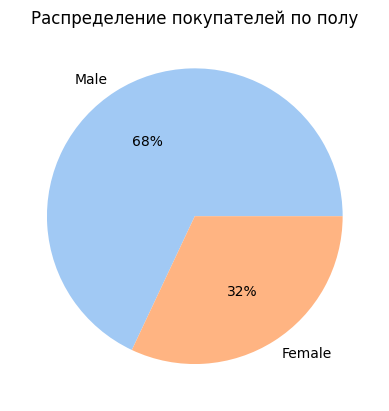

In [14]:

gender_values = df['Gender'].value_counts().values
gender_labels = df['Gender'].value_counts().index

colors = sns.color_palette('pastel')
plt.pie(x=gender_values, labels=gender_labels, autopct='%1.0f%%', colors=colors)
plt.title("Распределение покупателей по полу")
plt.show()

##Определите, какой пол (и отдельно возраст) покупает больше всего, чаще всего, самые дорогие товары

###Определите, какой пол (и отдельно возраст) покупает больше всего

In [15]:
gender_purchase_amount = df['Gender'].mode()
age_purchase_amount = df['Age'].mode()


print(f'Больше всего покупают люди с полом: {gender_purchase_amount.values}')
print(f'Больше всего покупают люди с возрастом: {age_purchase_amount.values}')


Больше всего покупают люди с полом: ['Male']
Больше всего покупают люди с возрастом: [69]


###Определите, какой пол покупает чаще всего

In [16]:

frequency_map = {
    'Weekly': 52,          # Раз в неделю, 52 раза в год
    'Bi-Weekly': 104,      # Два раза в неделю, 104 раза в год
    'Fortnightly': 26,     # Раз в две недели, 26 раз в год
    'Monthly': 12,         # Раз в месяц, 12 раз в год
    'Quarterly': 4,        # Раз в квартал, 4 раза в год
    'Every 3 Months': 4,   # Раз в 3 месяца (эквивалент Quarterly), 4 раза в год
    'Annually': 1          # Раз в год, 1 раз в год
}

#Сброс индексов
grouped_counts = (
      df.groupby("Gender")['Frequency of Purchases']
      .value_counts()
      .reset_index(name='Counts')
)

#Новый столбец, где преобразуем значения Frequency of Purchases' в числа
grouped_counts['Value_of_frequency'] = (
    grouped_counts['Frequency of Purchases']
    .map(frequency_map)
)

#Умножаем столбцы 'Counts' и 'Value_of_frequency', получаем общее количество покупок
grouped_counts['Total_purchases'] = (
    grouped_counts['Value_of_frequency']
    * grouped_counts['Counts']
)

#Суммируем покупки по полу
grouped_counts_by_gender = grouped_counts.groupby('Gender')['Total_purchases'].sum()

#Считаем количество записей по полу
purchase_by_gender = df['Gender'].value_counts()

#Делим расчетную частоту на количество записей, чтобы получить
#нормальзованную частоту по  полу
normalized_purchases_by_gender = grouped_counts_by_gender / purchase_by_gender

#Выводим пол, который чаще совершал покупки
print(normalized_purchases_by_gender.idxmax())

Female


###Определите люди какого возраста покупают чаще всего

In [17]:
#определите люди какого возраста покупают чаще всего

frequency_map = {
    'Weekly': 52,          # Раз в неделю, 52 раза в год
    'Bi-Weekly': 104,      # Два раза в неделю, 104 раза в год
    'Fortnightly': 26,     # Раз в две недели, 26 раз в год
    'Monthly': 12,         # Раз в месяц, 12 раз в год
    'Quarterly': 4,        # Раз в квартал, 4 раза в год
    'Every 3 Months': 4,   # Раз в 3 месяца (эквивалент Quarterly), 4 раза в год
    'Annually': 1          # Раз в год, 1 раз в год
}

#Сброс индексов
grouped_counts = (
      df.groupby("Age")['Frequency of Purchases']
      .value_counts()
      .reset_index(name='Counts')
)

#Новый столбец, где преобразуем значения Frequency of Purchases' в числа
grouped_counts['Value_of_frequency'] = (
    grouped_counts['Frequency of Purchases']
    .map(frequency_map)
)

#Умножаем столбцы 'Counts' и 'Value_of_frequency', получаем общее количество покупок
grouped_counts['Total_purchases'] = (
    grouped_counts['Value_of_frequency']
    * grouped_counts['Counts']
)

#Суммируем покупки по возрасту
grouped_counts_by_gender = grouped_counts.groupby('Age')['Total_purchases'].sum()

#Считаем количество записей по возрасту
purchase_by_gender = df['Age'].value_counts()

#Делим расчетную частоту на количество записей, чтобы получить
#нормальзованную частоту по  возрасту
normalized_purchases_by_gender = grouped_counts_by_gender / purchase_by_gender

#Выводим возраст людей, которые чаще совершал покупки
print(normalized_purchases_by_gender.idxmax())

26


###Определите, какой пол (и отдельно возраст) покупает самые дорогие товары

In [18]:
# Группируем по полу и для каждого возраста находим макс цену покупки
max_purchase_by_gender = df.groupby("Gender")['Purchase Amount (USD)'].max()

# Группируем по возрасту и для каждого возраста находим макс цену покупки
max_purchase_by_age = df.groupby("Age")['Purchase Amount (USD)'].max()

# Пол с самой дорогой покупкой
max_gender_purchase = max_purchase_by_gender.idxmax()
max_gender_value = max_purchase_by_gender.max()


# Возраст с самой дорогой покупкой
max_age_purchase = max_purchase_by_age.idxmax()
max_age_value = max_purchase_by_age.max()

print(f"Пол, покупающий самые дорогие товары: {max_gender_purchase} (с суммой {max_gender_value} USD)")
print(f"Возраст, покупающий самые дорогие товары: {max_age_purchase} (с суммой {max_age_value} USD)")


Пол, покупающий самые дорогие товары: Female (с суммой 100 USD)
Возраст, покупающий самые дорогие товары: 18 (с суммой 100 USD)


##Определите, есть ли зависимость между цветом одежды и сезоном.

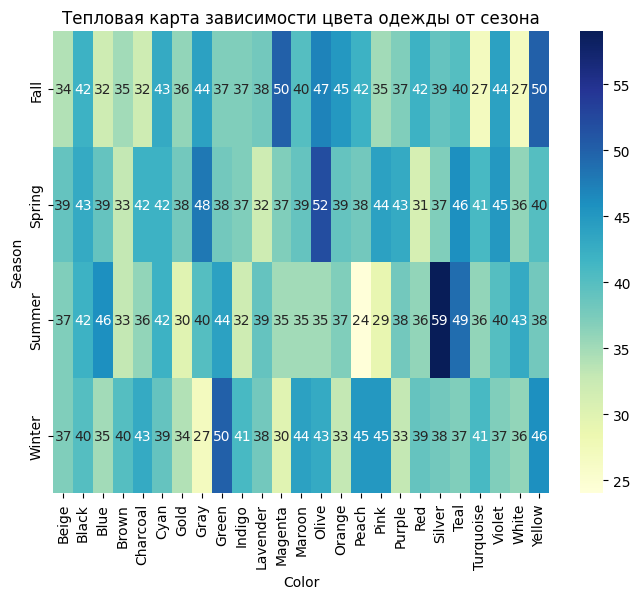

In [19]:
# Создаем таблицу сопряженности
contingency_table = pd.crosstab(df['Season'], df['Color'])

# Тепловая карта
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Тепловая карта зависимости цвета одежды от сезона")
plt.show()

На тепловой карте не видно определенных зависимостей

In [20]:
# Примененяем критерий хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Результаты
print("Хи-квадрат:", chi2)
print("p-value:", p)

# Вывод
if p <= 0.05:
    print("Между цветом одежды и сезоном есть статистически значимая зависимость.")
else:
    print("Зависимости между цветом одежды и сезоном не обнаружено.")



Хи-квадрат: 64.6506366841786
p-value: 0.718551112120402
Зависимости между цветом одежды и сезоном не обнаружено.


##Посчитайте наш сезонный mau (уникальных пользователей за сезон) и его динамику.

In [21]:
#Выситываем mau для каждого сезона
seasonal_mau = df.groupby('Season')['Customer ID'].nunique().reset_index()

seasonal_mau_columns = ['Season', 'mau']
seasonal_mau.columns = seasonal_mau_columns

#Организуем порядок сезонов
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_mau['Season'] = pd.Categorical(seasonal_mau['Season'], categories=season_order, ordered=True)
seasonal_mau = seasonal_mau.sort_values('Season')

#Высчитываем процентное изменение mau
seasonal_mau['mau_change'] = seasonal_mau['mau'].pct_change()*100
print(seasonal_mau)

   Season  mau  mau_change
3  Winter  971         NaN
1  Spring  999    2.883625
2  Summer  955   -4.404404
0    Fall  975    2.094241


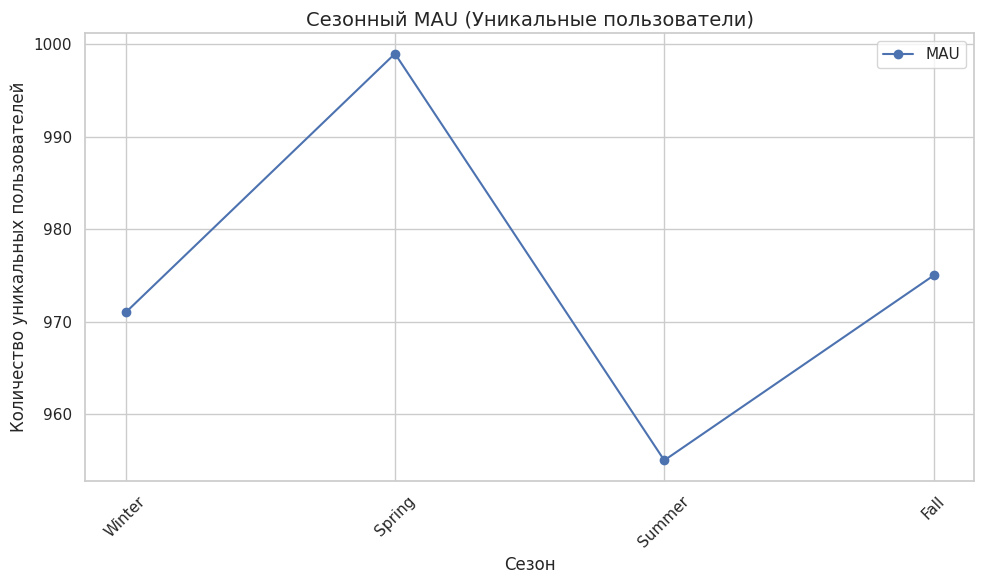

In [22]:
sns.set(style="whitegrid")

# Создаём график для MAU
plt.figure(figsize=(10, 6))

# Линия для MAU по сезонам
plt.plot(seasonal_mau['Season'], seasonal_mau['mau'], marker='o', color='b', label='MAU')

#Оформление
plt.title('Сезонный MAU (Уникальные пользователи)', fontsize=14)
plt.xlabel('Сезон', fontsize=12)
plt.ylabel('Количество уникальных пользователей', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

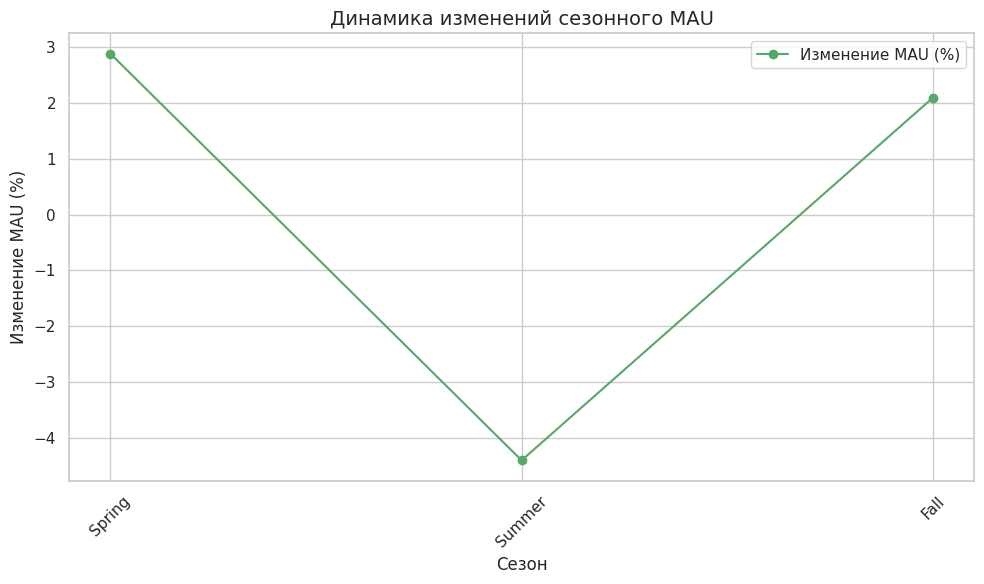

In [23]:
# Создаём график для изменения MAU
plt.figure(figsize=(10, 6))

# Линия для динамики изменений MAU в процентах
plt.plot(seasonal_mau['Season'], seasonal_mau['mau_change'], marker='o', color='g', label='Изменение MAU (%)')

#Оформление
plt.title('Динамика изменений сезонного MAU', fontsize=14)
plt.xlabel('Сезон', fontsize=12)
plt.ylabel('Изменение MAU (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

##Найдите самую популярную букву в названии одежды.

In [24]:
# Объединяем все названия из категории одежда в одну строку
all_letters = ''.join(df[df['Category'] == 'Clothing']['Item Purchased'])\
                .replace(' ', '').lower()

# Подсчитываем частоты букв
letter_counts = Counter(all_letters)

# Самая популярная буква
most_common_letter = letter_counts.most_common(1)[0]

print(f"Самая популярная буква: '{most_common_letter[0]}', встречается {most_common_letter[1]} раз.")


Самая популярная буква: 's', встречается 2068 раз.
